In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df.head()

,image_id,label
0,train_1a,arroz
1,train_1b,caramelo
2,train_1c,jamon
3,train_1d,cafe
4,train_2a,vinagre


In [4]:
label_encoder = preprocessing.LabelEncoder()
df['label']= label_encoder.fit_transform(df['label']) 

In [5]:
label_encoder.inverse_transform(df['label'].unique())

array(['arroz', 'caramelo', 'jamon', 'cafe', 'vinagre', 'chocolate',
       'azucar', 'agua', 'jugo', 'leche', 'gaseosa', 'nueces', 'chips',
       'especias', 'cereal', 'frijoles', 'torta', 'miel', 'harina',
       'pasta', 'salsatomate', 'te', 'maiz', 'aceite', 'pescado'],
      dtype=object)

In [6]:
df.to_csv('train_encoded.csv',index=False)

In [7]:
df2 = pd.read_csv('./train_encoded.csv')
df2.head()

,image_id,label
0,train_1a,2
1,train_1b,5
2,train_1c,13
3,train_1d,4
4,train_2a,24


In [8]:
n = 0
img_name = df.iloc[n, 0]
clase = df.iloc[n, 1]

print('Image name: {}'.format(img_name))
print('Clase: {}'.format(clase))

Image name: train_1a
Clase: 2


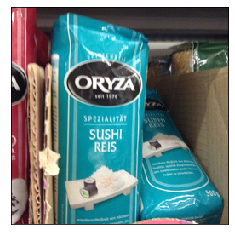

In [9]:
def show_class(image, clase):
    """Show image with class"""
    plt.imshow(image)#, plt.title(clase)
    plt.xticks([]), plt.yticks([])
    plt.show()

show_class(io.imread(os.path.join('./train_img/', img_name+'.png')),
               clase)

In [10]:
class ImageClassificationDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.clases = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.clases)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.clases.iloc[idx, 0]+'.png')
        image = io.imread(img_name)
        label = self.clases.iloc[idx, 1]
        sample = {'imagen': image, 'clase': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (256, 256, 3) 2


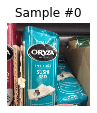

1 (256, 256, 3) 5


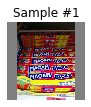

2 (256, 256, 3) 13


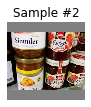

3 (256, 256, 3) 4


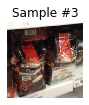

In [11]:
image_dataset = ImageClassificationDataset(csv_file='train_encoded.csv',
                                    root_dir='./train_img/')

#fig = plt.figure()

for i in range(len(image_dataset)):
    sample = image_dataset[i]

    print(i, sample['imagen'].shape, sample['clase'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_class(sample['imagen'],sample['clase'])

    if i == 3:
        plt.show()
        break

In [49]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['imagen'], sample['clase']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'imagen': img, 'clase': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['imagen'], sample['clase']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'imagen': image, 'clase': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['imagen'], sample['clase']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'imagen': torch.from_numpy(image),
                'clase': label}

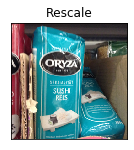

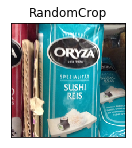

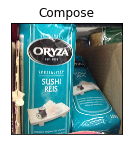

In [13]:
scale = Rescale(256)
crop = RandomCrop(200)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = image_dataset[0]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_class(transformed_sample['imagen'],transformed_sample['clase'])

plt.show()

In [14]:
transformed_dataset = ImageClassificationDataset(csv_file='train_encoded.csv',
                                           root_dir='./train_img',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[0]

    #print(i, sample['imagen'].size(), sample['clase'].size())

    if i == 3:
        break

0 torch.Size([4, 3, 224, 224]) tensor([ 8, 22, 18, 17])
1 torch.Size([4, 3, 224, 224]) tensor([19, 16,  1, 22])
2 torch.Size([4, 3, 224, 224]) tensor([16, 14,  6,  9])
3 torch.Size([4, 3, 224, 224]) tensor([ 9,  4, 13, 15])


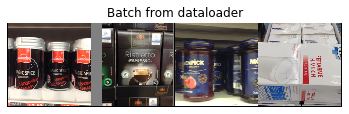

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_class_batch(sample_batched):
    """Show image with label for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['imagen'], sample_batched['clase']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['imagen'].shape,
          sample_batched['clase'])

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_class_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [16]:
# Parameters and DataLoaders

batch_size = 30

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [98]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trainset = datasets.ImageFolder(root='./train_img', transform=data_transform)
trainset.idx_to_class = {v: k for k, v in images.class_to_idx.items()}

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

AttributeError: 'Tensor' object has no attribute 'class_to_idx'

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [74]:
net = torch.hub.load('pytorch/vision:v0.5.0', 'inception_v3', pretrained=False)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net.to(device)
net.eval()

Using cache found in /home/lcarranza/.cache/torch/hub/pytorch_vision_v0.5.0


Let's use 2 GPUs!


DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

In [75]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [1]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    print('Starting Epoch')
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
            
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Starting Epoch


NameError: name 'trainloader' is not defined

In [79]:
PATH = './model_test.pth'
torch.save(net.state_dict(), PATH)

In [80]:
testset = datasets.ImageFolder(root='./train_img', transform=data_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


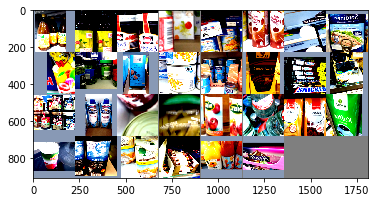

tensor(14) tensor(0) tensor(13) tensor(9)


In [84]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


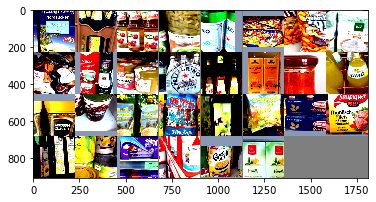

GroundTruth:  tensor(3) tensor(11) tensor(14) tensor(10)


In [86]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [88]:
net = torch.hub.load('pytorch/vision:v0.5.0', 'inception_v3', pretrained=False)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net.to(device)
net.load_state_dict(torch.load(PATH))
net.eval()

Using cache found in /home/lcarranza/.cache/torch/hub/pytorch_vision_v0.5.0


Let's use 2 GPUs!


DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

In [89]:
outputs = net(images)

In [91]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

Predicted:  tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0') tensor(0, device='cuda:0')


In [92]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 2 %


In [96]:
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(25):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 :  0 %
Accuracy of     2 :  0 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 :  0 %
Accuracy of    10 :  0 %
Accuracy of    11 :  0 %
Accuracy of    12 :  0 %
Accuracy of    13 :  0 %
Accuracy of    14 :  0 %
Accuracy of    15 :  0 %
Accuracy of    16 :  0 %
Accuracy of    17 :  0 %
Accuracy of    18 :  0 %
Accuracy of    19 :  0 %
Accuracy of    20 :  0 %
Accuracy of    21 :  0 %
Accuracy of    22 :  0 %
Accuracy of    23 :  0 %
Accuracy of    24 :  0 %
